In [1]:
import igraph as ig
import leidenalg as la #https://leidenalg.readthedocs.io/en/latest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from igraph import Graph #https://python.igraph.org/en/stable/install.html
from modwt import modwt, modwtmra
from scipy.stats import t
from fMRI_pearson import fMRISeq
from sklearn.metrics import normalized_mutual_info_score as NMI
import pickle

In [2]:
# load data
data = loadmat(r"E:\NS\Primate fMRI\data\awake_fmri")['awake_fmri']
# load consensus partition
with open(r'E:\\NS\\Primate fMRI\\community\\results\\l40_s20_partition.pkl','rb') as f:
    membership = pickle.load(f)
print(membership)
n_clusters = max(membership)+1
membership = np.array(membership)

[0, 0, 3, 0, 5, 3, 1, 6, 0, 4, 1, 1, 0, 1, 0, 1, 1, 7, 5, 0, 4, 1, 3, 0, 0, 8, 7, 2, 4, 6, 5, 1, 4, 1, 3, 0, 5, 1, 0, 1, 5, 2, 1, 0, 2, 1, 4, 4, 0, 5, 2, 3, 5, 3, 3, 1, 4, 2, 5, 2, 0, 6, 6, 5, 0, 0, 2, 3, 3, 2, 0, 3, 7, 1, 1, 6, 2, 2, 0, 7, 4, 0, 1, 2, 7, 1, 3, 4, 2, 0, 2]


In [3]:
data00 = data[0,0]
fmri_seq = fMRISeq(data00,l_window=20,step=10)
fmri_seq = fmri_seq.load_results('E:\\NS\\Primate fMRI\\community\\results\\l40_s20_%d_%d.pkl'%(0,1))
temp_memb_commu = fmri_seq.membership_community()
temp_memb_commu = temp_memb_commu.transpose(1,2,0)
con_memb_commu = np.zeros((n_clusters,fmri_seq.num_node))
for i in range(n_clusters):
    con_memb_commu[i,:] = (membership == i)

In [4]:
ct_mat = np.matmul(con_memb_commu,temp_memb_commu)/np.sum(con_memb_commu,axis=1,keepdims=True) 
print(ct_mat.shape)

(22, 9, 5)


Text(0.5, 25.722222222222214, 'Temporal community')

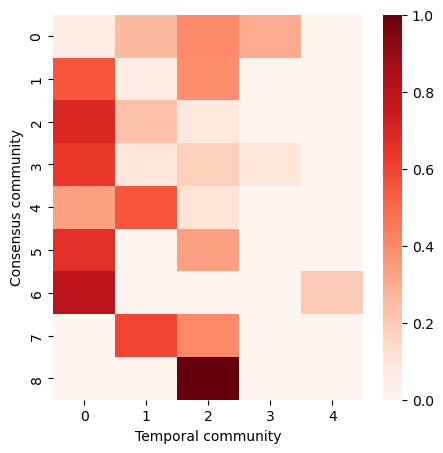

In [5]:
plt.figure(figsize=(5,5))
sns.heatmap(ct_mat[2],cmap='Reds')
plt.ylabel("Consensus community")
plt.xlabel("Temporal community")

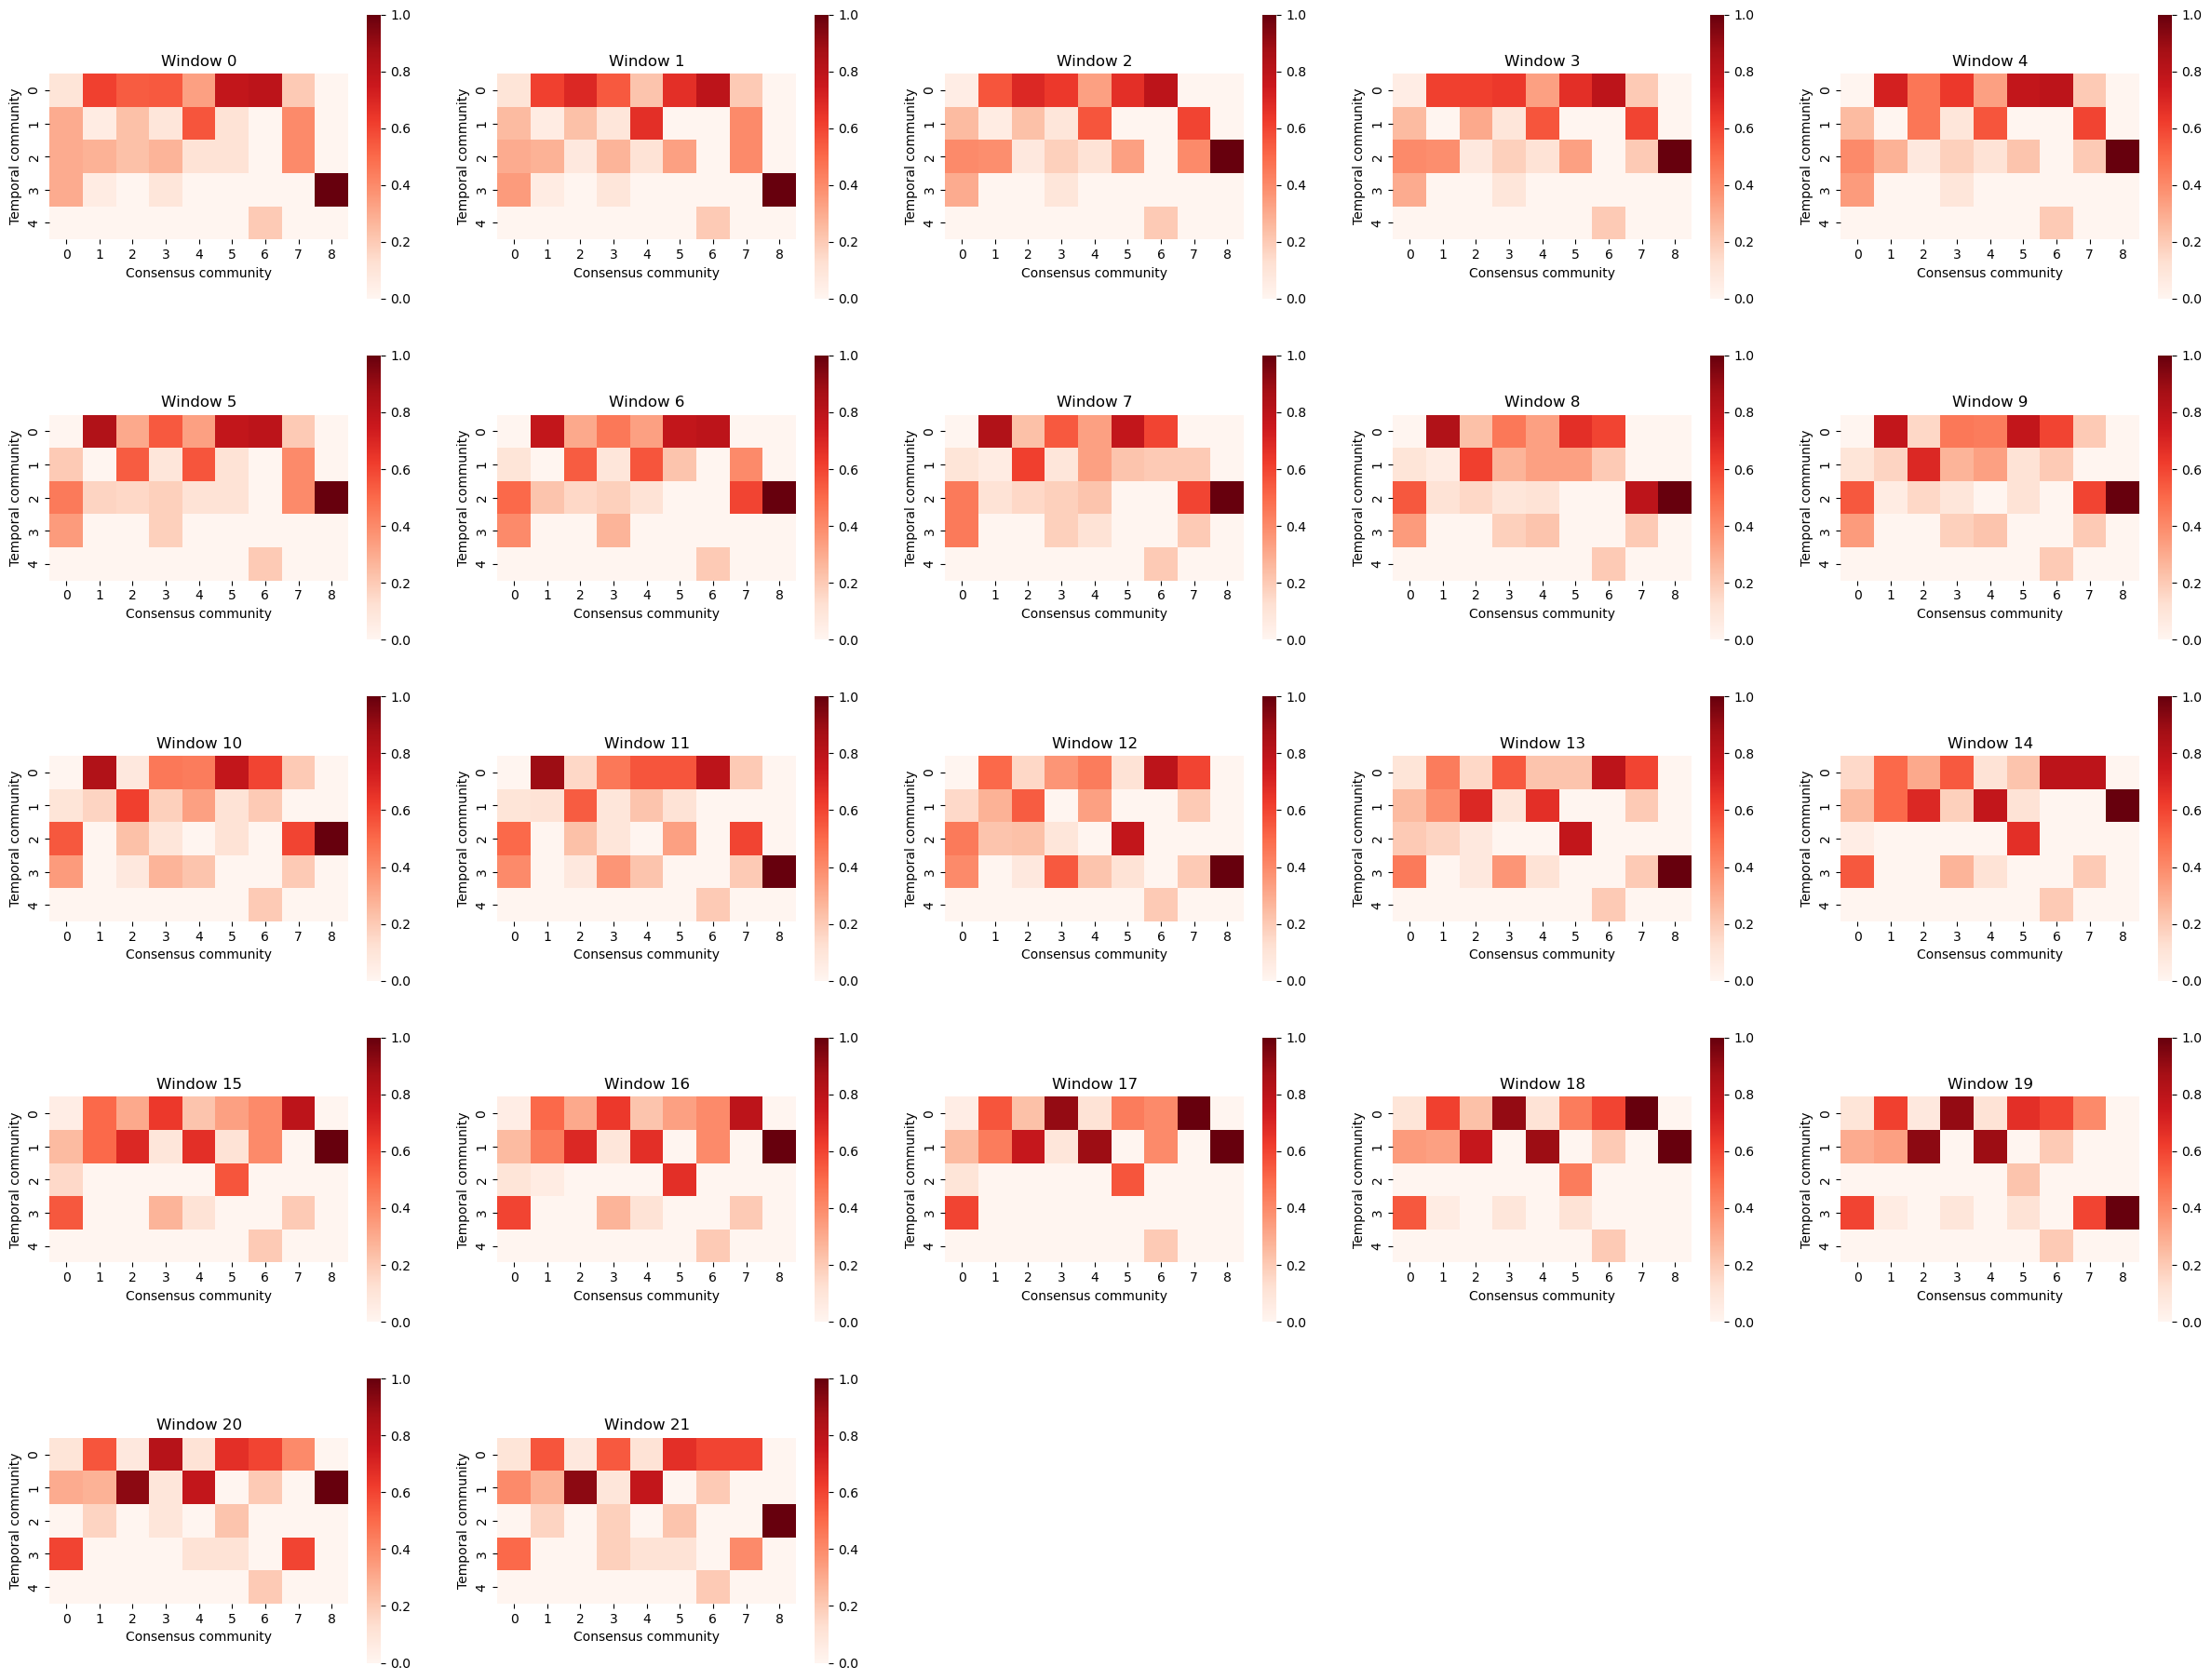

In [6]:
# plot the 22 heatmaps
plt.figure(figsize=(30,23))
for i in range(22):
    ax = plt.subplot(5,5,i+1)
    sns.heatmap(ct_mat[i].T,cmap='Reds',square = True)
    plt.ylabel("Temporal community")
    plt.xlabel("Consensus community")
    plt.title("Window %d"%i)


In [7]:
plt.savefig(r'E:\\NS\\Primate fMRI\\community\\results\\l40_s20_ct_mat_0_1.png',dpi=500)

<Figure size 640x480 with 0 Axes>

In [8]:
ct_mat_list = []
con_memb_commu = np.zeros((n_clusters,91))
for i in range(n_clusters):
    con_memb_commu[i,:] = (membership == i)
for i in range(1):
    for j in range(data.shape[1]):
        data_seq = data[i,j]
        if data_seq.shape[1] < 10:
            continue
        # initialize the fMRISeq class
        fmri_seq = fMRISeq(data_seq,l_window =20,step =10)
        fmri_seq = fmri_seq.load_results('E:\\NS\\Primate fMRI\\community\\results\\l40_s20_%d_%d.pkl'%(i,j))
        temp_memb_commu = fmri_seq.membership_community() # (n_clusters,n_windows,n_nodes)
        temp_memb_commu = temp_memb_commu.transpose(1,2,0) # (n_windows,n_nodes,n_clusters)
        ct_mat = np.matmul(con_memb_commu,temp_memb_commu)/np.sum(con_memb_commu,axis=1,keepdims=True) #(n_windows,n_c,n_t)
        ct_mat_list = ct_mat_list + [*ct_mat]



In [9]:
ct_mat_array = np.column_stack(ct_mat_list)

In [10]:
# perform hierachial clustering on the ct_mat_list
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster

# calculate the distance matrix
dist_mat = pdist(ct_mat_array.T,metric='euclidean')
dist_mat = squareform(dist_mat)
print(dist_mat.shape)


(1034, 1034)


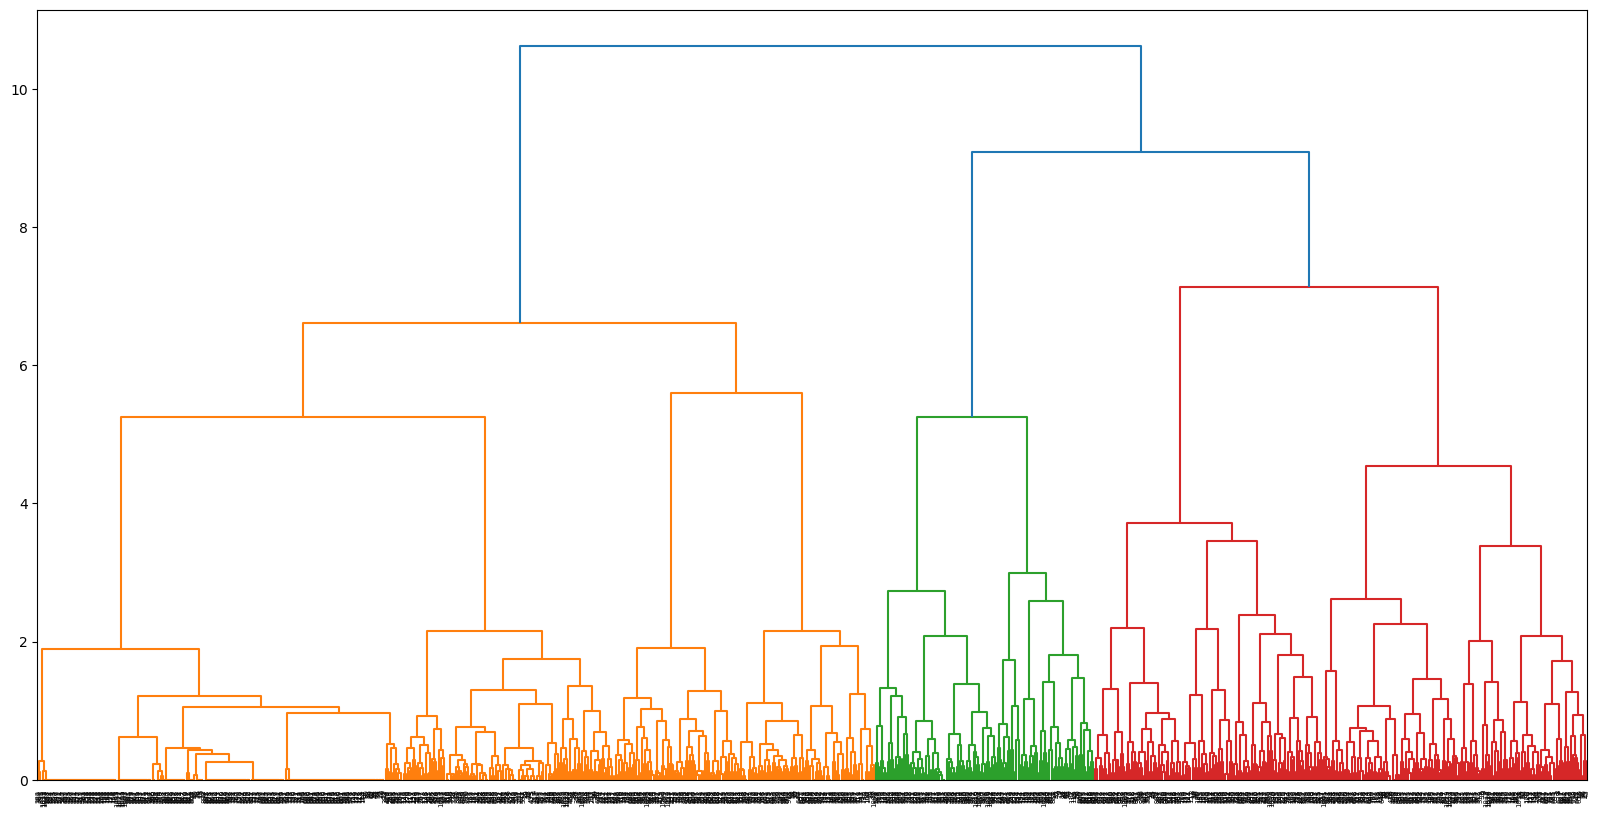

In [11]:
# perform hierachial clustering
ct_mat_array2 = ct_mat_array[0:8,:]
Z = linkage(ct_mat_array2.T,method='ward')
# plot the dendrogram
plt.figure(figsize=(20,10))
dendro = dendrogram(Z)

In [46]:
# get the cluster labels
cluster_labels = fcluster(Z, t=3, criterion='distance')
print(np.max(cluster_labels))

12


Text(0.5, 25.722222222222214, 'Consensus community')

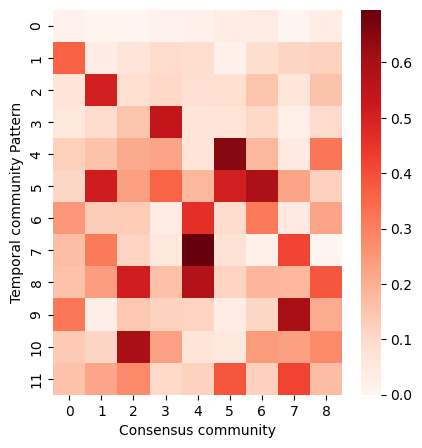

In [47]:
# get the mean value of each cluster
cluster_mean = np.zeros((np.max(cluster_labels),ct_mat_array.shape[0]))
for i in range(np.max(cluster_labels)):
    cluster_mean[i,:] = np.mean(ct_mat_array[:,cluster_labels==i+1],axis=1)
plt.figure(figsize=(5,5))
sns.heatmap(cluster_mean,cmap='Reds',square=True)
plt.ylabel("Temporal community Pattern")
plt.xlabel("Consensus community")

In [48]:
temp_memb_commu_list = []
for i in range(n_clusters):
    con_memb_commu[i,:] = (membership == i)
for i in range(1):
    for j in range(data.shape[1]):
        data_seq = data[i,j]
        if data_seq.shape[1] < 10:
            continue
        # initialize the fMRISeq class
        fmri_seq = fMRISeq(data_seq,l_window =20,step =10)
        fmri_seq = fmri_seq.load_results('E:\\NS\\Primate fMRI\\community\\results\\l40_s20_%d_%d.pkl'%(i,j))
        temp_memb_commu = fmri_seq.membership_community() # (n_clusters,n_windows,n_nodes)
        temp_memb_commu = temp_memb_commu.transpose(1,0,2) # (n_windows,n_clusters,n_nodes)
        temp_memb_commu_list = temp_memb_commu_list + [*temp_memb_commu.reshape(-1,91)]

In [49]:
temp_memb_commu_array = np.row_stack(temp_memb_commu_list)
print(temp_memb_commu_array.shape)

(1034, 91)


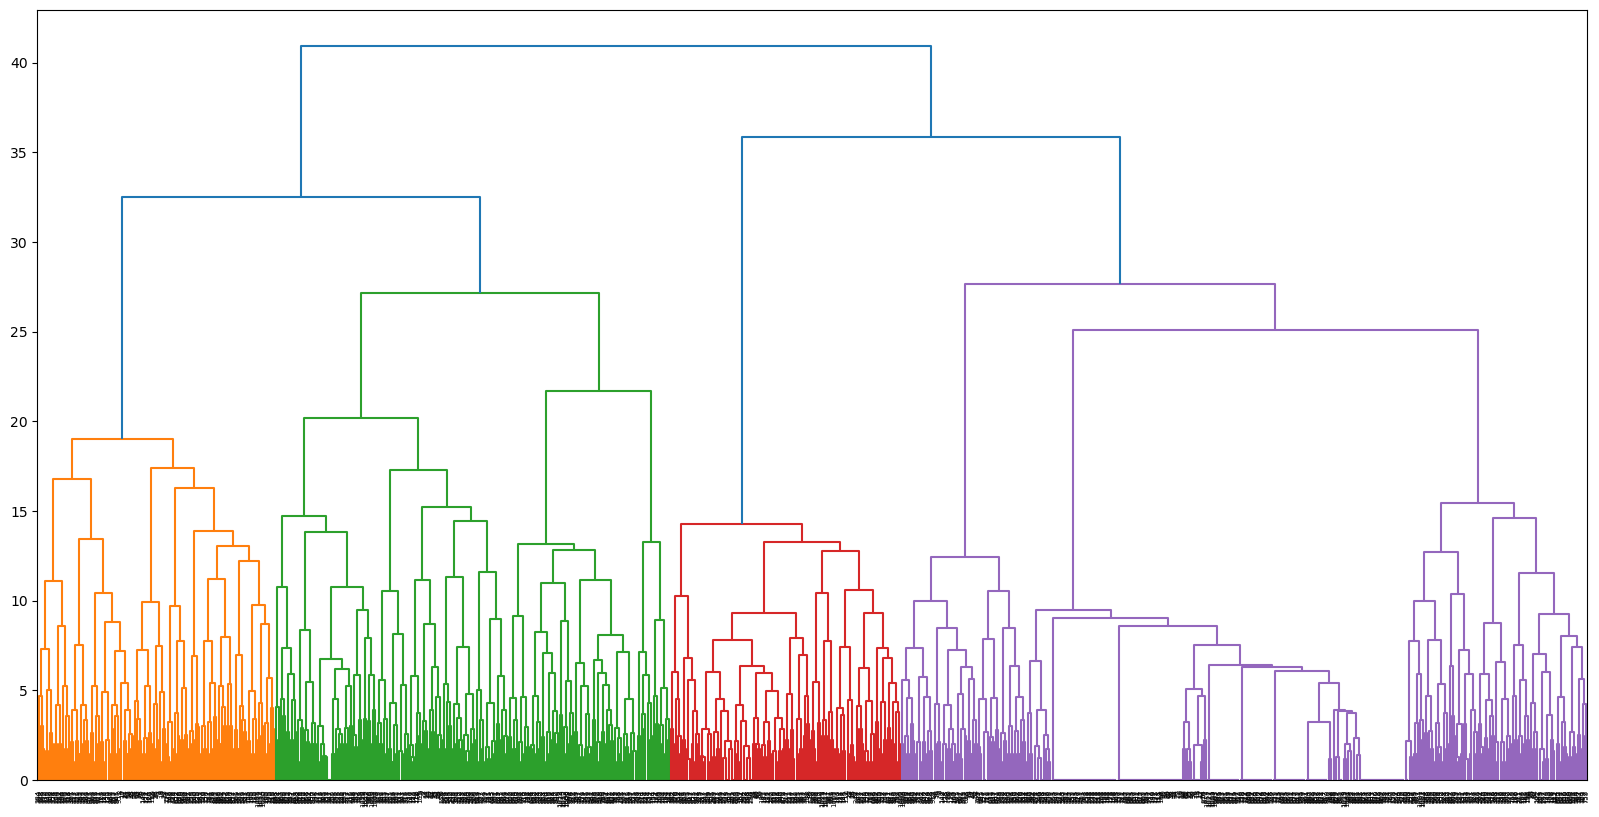

In [50]:
Z2 = linkage(temp_memb_commu_array,method='ward')
# plot the dendrogram
plt.figure(figsize=(20,10))
dendro2 = dendrogram(Z2)

In [51]:
# get the cluster labels
cluster_labels2 = fcluster(Z2, t=20, criterion='distance')
print(np.max(cluster_labels2))

9


Text(0.5, 47.7222222222222, 'Temporal Community Pattern')

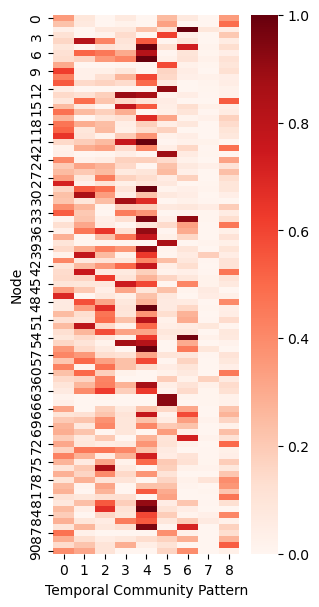

In [71]:
# get the mean value of each cluster
cluster_mean2 = np.zeros((np.max(cluster_labels2),temp_memb_commu_array.shape[1]))
for i in range(np.max(cluster_labels2)):
    cluster_mean2[i,:] = np.mean(temp_memb_commu_array[cluster_labels2==i+1,:],axis=0)
plt.figure(figsize=(3,7))
sns.heatmap(cluster_mean2.T,cmap='Reds')
plt.ylabel("Node")
plt.xlabel("Temporal Community Pattern") # 得到和PCA类似的结果

Text(70.72222222222221, 0.5, 'Temporal community pattern')

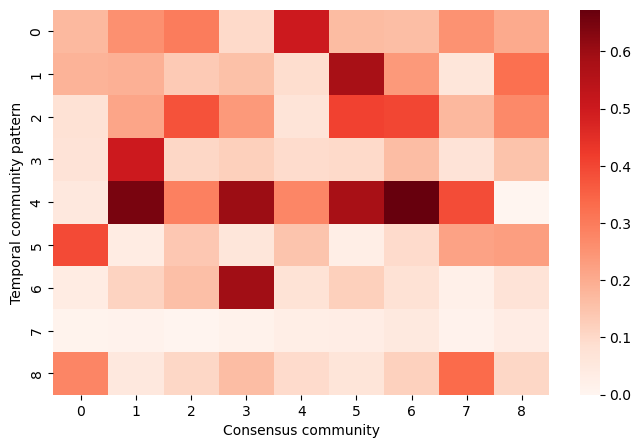

In [61]:
identity_matrix = con_memb_commu@cluster_mean2.T/np.sum(con_memb_commu,axis=1,keepdims=True)
plt.figure(figsize=(8,5))
sns.heatmap(identity_matrix.T,cmap='Reds')
plt.xlabel("Consensus community")
plt.ylabel("Temporal community pattern")

In [62]:
projection_temp_commu= np.matmul(temp_memb_commu_array,cluster_mean2.T)/np.sum(cluster_mean2,axis=1,keepdims=True).T

In [63]:
print(projection_temp_commu.shape)

(1034, 9)


In [64]:
n_clusters_temp_list = []
cluster_map_list = []
labels = np.array(cluster_labels2)-1 # 0,1,...,8
current_num = 0
for i in range(1):
    for j in range(data.shape[1]):
        data_seq = data[i,j]
        if data_seq.shape[1] < 10:
            continue
        # initialize the fMRISeq class
        fmri_seq = fMRISeq(data_seq,l_window =20,step =10)
        fmri_seq = fmri_seq.load_results('E:\\NS\\Primate fMRI\\community\\results\\l40_s20_%d_%d.pkl'%(i,j))
        n_clusters_temp_list.append(fmri_seq.n_clusters)
        temp_memb_commu = fmri_seq.membership_community() # (n_clusters,n_windows,n_nodes)
        temp_memb_commu = temp_memb_commu.transpose(1,0,2) # (n_windows,n_clusters,n_nodes)
        #temp_memb_commu_list = temp_memb_commu_list + [*temp_memb_commu.reshape(-1,91)]

        # cluster_map: (n_windows,n_mean_temp_commu); (i,j) is 1 if jth mean temporal community occurs in ith window
        label_trial = labels[current_num:current_num+fmri_seq.n_window*fmri_seq.n_clusters].reshape(fmri_seq.n_window,fmri_seq.n_clusters)
        cluster_map = np.zeros((fmri_seq.n_window,cluster_mean2.shape[0]))
        for k in range(fmri_seq.n_window):
            cluster_map[k,label_trial[k,:]] = 1
        current_num = current_num + fmri_seq.n_window*fmri_seq.n_clusters
        cluster_map_list.append(cluster_map)

In [65]:
cluster_map_array = np.row_stack(cluster_map_list)
print(cluster_map_array.shape)

(154, 9)


<AxesSubplot:>

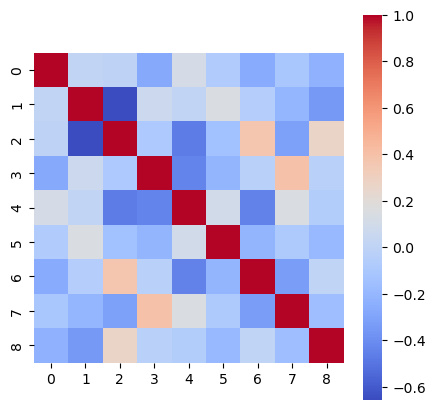

In [66]:
cor_cluster_map = np.corrcoef(cluster_map_array.T)
plt.figure(figsize=(5,5))
sns.heatmap(cor_cluster_map,cmap='coolwarm',square=True)

In [67]:
#temp_memb_commu_list = []
projection_temp_commu_list = []
for i in range(n_clusters):
    con_memb_commu[i,:] = (membership == i)
for i in range(1):
    for j in range(data.shape[1]):
        data_seq = data[i,j]
        if data_seq.shape[1] < 10:
            continue
        # initialize the fMRISeq class
        fmri_seq = fMRISeq(data_seq,l_window =20,step =10)
        fmri_seq = fmri_seq.load_results('E:\\NS\\Primate fMRI\\community\\results\\l40_s20_%d_%d.pkl'%(i,j))
        temp_memb_commu = fmri_seq.membership_community() # (n_clusters,n_windows,n_nodes)
        temp_memb_commu = temp_memb_commu.transpose(1,0,2) # (n_windows,n_clusters,n_nodes)
        #temp_memb_commu_list = temp_memb_commu_list + [*temp_memb_commu.reshape(-1,91)]
        projection_temp_commu= np.matmul(temp_memb_commu,cluster_mean2.T)/np.sum(cluster_mean2,axis=1,keepdims=True).T # (n_windows,n_clusters_temp,n_clusters_con)
        projection_temp_commu_list = projection_temp_commu_list + [projection_temp_commu]

<AxesSubplot:>

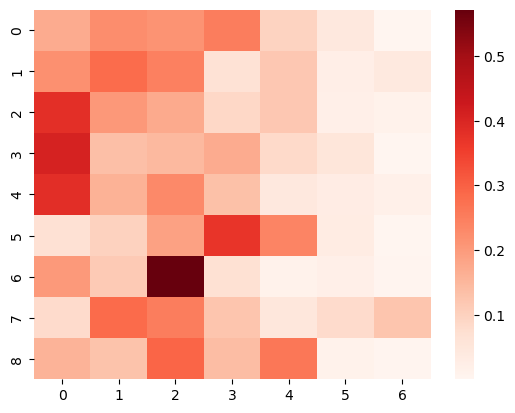

In [68]:
sns.heatmap(projection_temp_commu_list[0][0].T,cmap='Reds')